<a href="https://colab.research.google.com/github/JANE0015/Learn-Cloud/blob/main/Simple_GRU_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Include Library

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
sb.set()

import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Extract dataset

In [ ]:
dataset = pd.read_json('/content/drive/MyDrive/2022/NTU/IE4483/train.json', encoding='utf-8')

In [ ]:
rev = dataset["reviews"]
senti = dataset["sentiments"]

In [ ]:
rev.shape

(7401,)

In [ ]:
senti.shape

(7401,)

Percentage of positive reviews = 85.38 %


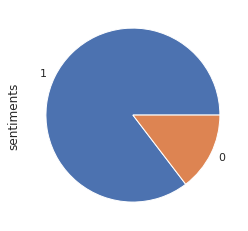

In [ ]:
sen = senti.value_counts()
print(f'Percentage of positive reviews = {round(sen[1]/len(rev)*100, 2)} %')
sen.plot(kind="pie");

In [ ]:
dataset.head()

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [ ]:
emojis = {':)':'smile' , ':-)':'smile' , ';d':'wink' , ':-E':'vampire' , ':(':'sad' ,
         ':-(':'sad' , ':-<': 'sad' ,  ':P':'raspberry' , ':O':'surprised' , 
         ':-@':'shocked' , ':@':'shocked' , ':$':'confused' , ':\\':'annoyed' ,
         ':#':'mute' , ':X':'mute' , ':^)':'smile' , ':-&': 'confused' , '$_$':'greedy' ,
         '@@':'eyeroll', ':-!':'confused' , ':-D':'smile' , ':-0':'yell' , 'O.o':'confused' ,
         '<(-_-)>':'robot' , 'd[-_-]b':'dj' , ":')":'sadsmile' , ';)':'wink' ,
         ';-)':'wink' , 'O:-)':'angel' , 'O*-)':'angel' , '(:-D':'gossip' , '=^.^=':'cat'}

Clean Dataset

In [ ]:
def clean_data(data):
    data = str(data).lower()
    data = re.sub(r"@\S+ ", r'',data)
    
    for emoji in emojis:
        data = data.replace(emoji, emojis[emoji])
    data = re.sub("\s+", ' ', data)
    data = re.sub("\n", " ", data)
    letters = re.sub("[^a-zA-Z]", " ", data)
    
    return letters
    

In [ ]:
def remove_ext_spacing(data):
    data = re.sub(" +", " ", data)
    
    return data  

In [ ]:
sw = stopwords.words('english')

In [ ]:
def stop_words(words):
    clean_text =[]
    for w in words:
        if w not in sw:
            clean_text.append(w)
    
    return clean_text
            

In [ ]:
clean_text_1 = rev.apply(lambda x:clean_data(x))

In [ ]:
clean_text_1.head()

0    i bought this belt for my daughter in law for ...
1    the size was perfect and so was the color  it ...
2    fits and feels good  esp  for doing a swim rac...
3    these socks are absolutely the best  i take pi...
4    thank you so much for the speedy delivery they...
Name: reviews, dtype: object

In [ ]:
clean_text_2 = clean_text_1.apply(lambda x:remove_ext_spacing(x))

Split the sentence

In [ ]:
#split into list of words
clean_text_3 = clean_text_2.apply(lambda x:x.split(" ") )

Remove stopwords

In [ ]:
clean_text_4 = clean_text_3.apply(lambda x:stop_words(x))

Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
clean_text_5 = clean_text_4.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

In [ ]:
clean_text_6 = clean_text_5.apply(lambda x:" ".join(x))

In [ ]:
clean_text_6.shape

(7401,)

Cleaned dataset

In [ ]:
cleaned = pd.DataFrame(clean_text_6)
cleaned["sentiments"] = senti

In [ ]:
sen = cleaned["sentiments"] 
revi = cleaned["reviews"]

Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#splitting dataset into 33% and 67%
X_train, X_test, y_train, y_test = train_test_split(revi.values, sen.values, test_size=0.33, random_state=42)

In [ ]:
#Tokenized dataset
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
total_reviews = tokenizer_obj.fit_on_texts(revi) 

# length of a sentence
max_length = 100 

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

tokens =  tokenizer_obj.texts_to_sequences(revi)

pad = pad_sequences(tokens, maxlen=max_length, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pad, sen.values, test_size=0.33, random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ROS = RandomOverSampler(sampling_strategy=1)

In [ ]:
X_train_ros, y_train_ros =ROS.fit_resample(X_train, y_train)

In [ ]:
X_test_ros, y_test_ros = ROS.fit_resample(X_test, y_test)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

EMBEDDING_DIM = 100

print('Build model...')

#Implemeted GRU for training
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(GRU(units=32,  dropout=0.4, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))

#used binary crossentropy as the output is binary(0 or 1)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())


Build model...
Summary of the built model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1208900   
                                                                 
 dense_16 (Dense)            (None, 100, 32)           3232      
                                                                 
 dense_17 (Dense)            (None, 100, 64)           2112      
                                                                 
 gru_4 (GRU)                 (None, 32)                9408      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,223,685
Trainable params: 1,223,685
Non-trainable params: 0
_________________________________________________________________

In [ ]:
print('Train...')

history = model.fit(X_train, y_train, batch_size=128, epochs=25 , validation_data=(X_test, y_test), verbose=2)

Train...
Epoch 1/25
39/39 - 7s - loss: 0.0559 - accuracy: 0.9833 - val_loss: 0.4003 - val_accuracy: 0.8788 - 7s/epoch - 185ms/step
Epoch 2/25
39/39 - 6s - loss: 0.0584 - accuracy: 0.9837 - val_loss: 0.3766 - val_accuracy: 0.8903 - 6s/epoch - 159ms/step
Epoch 3/25
39/39 - 6s - loss: 0.0475 - accuracy: 0.9871 - val_loss: 0.4323 - val_accuracy: 0.8829 - 6s/epoch - 161ms/step
Epoch 4/25
39/39 - 6s - loss: 0.0488 - accuracy: 0.9883 - val_loss: 0.4872 - val_accuracy: 0.8895 - 6s/epoch - 160ms/step
Epoch 5/25
39/39 - 6s - loss: 0.0380 - accuracy: 0.9897 - val_loss: 0.4430 - val_accuracy: 0.8887 - 6s/epoch - 160ms/step
Epoch 6/25
39/39 - 6s - loss: 0.0402 - accuracy: 0.9905 - val_loss: 0.5099 - val_accuracy: 0.8895 - 6s/epoch - 160ms/step
Epoch 7/25
39/39 - 6s - loss: 0.0390 - accuracy: 0.9911 - val_loss: 0.4700 - val_accuracy: 0.8907 - 6s/epoch - 160ms/step
Epoch 8/25
39/39 - 6s - loss: 0.0389 - accuracy: 0.9887 - val_loss: 0.4627 - val_accuracy: 0.8817 - 6s/epoch - 159ms/step
Epoch 9/25
39/3

In [ ]:
print('Train...')

history = model.fit(X_train_ros, y_train_ros, batch_size=128, epochs=23 , validation_data=(X_test_ros, y_test_ros), verbose=2)

Train...
Epoch 1/23
67/67 - 11s - loss: 0.9173 - accuracy: 0.4976 - val_loss: 0.8513 - val_accuracy: 0.5000 - 11s/epoch - 157ms/step
Epoch 2/23
67/67 - 10s - loss: 2.0088 - accuracy: 0.4960 - val_loss: 1.8299 - val_accuracy: 0.4998 - 10s/epoch - 154ms/step
Epoch 3/23
67/67 - 10s - loss: 1.5216 - accuracy: 0.5028 - val_loss: 1.2588 - val_accuracy: 0.5000 - 10s/epoch - 154ms/step
Epoch 4/23
67/67 - 10s - loss: 1.4817 - accuracy: 0.4980 - val_loss: 2.3400 - val_accuracy: 0.5000 - 10s/epoch - 155ms/step
Epoch 5/23
67/67 - 10s - loss: 1.6343 - accuracy: 0.4992 - val_loss: 1.3734 - val_accuracy: 0.5000 - 10s/epoch - 155ms/step
Epoch 6/23
67/67 - 12s - loss: 1.1515 - accuracy: 0.5032 - val_loss: 1.1698 - val_accuracy: 0.5000 - 12s/epoch - 181ms/step
Epoch 7/23
67/67 - 10s - loss: 1.9671 - accuracy: 0.4989 - val_loss: 2.8016 - val_accuracy: 0.5000 - 10s/epoch - 155ms/step
Epoch 8/23
67/67 - 10s - loss: 1.6681 - accuracy: 0.5079 - val_loss: 1.4707 - val_accuracy: 0.5000 - 10s/epoch - 155ms/step

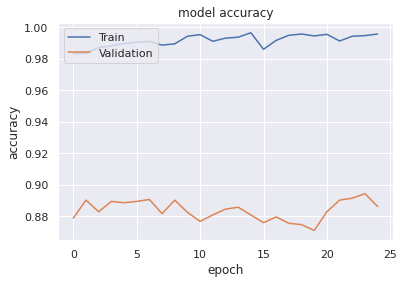

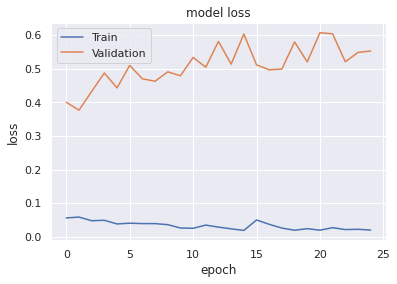

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Tokenized dataset
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
total_reviews = tokenizer_obj.fit_on_texts(revi) 

# length of a sentence
max_length = 100 

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

Building Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

EMBEDDING_DIM = 100

print('Build model...')

#Implemeted GRU for training
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))


#used binary crossentropy as the output is binary(0 or 1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())


Build model...
Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1208900   
                                                                 
 dense (Dense)               (None, 100, 64)           6464      
                                                                 
 dense_1 (Dense)             (None, 100, 64)           4160      
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,228,965
Trainable params: 1,228,965
Non-trainable params: 0
_________________________________________________________________

In [ ]:
print('Train...')

history = model.fit(X_train_pad, y_train, batch_size=128, epochs=23, validation_data=(X_test_pad, y_test), verbose=2)

Train...
Epoch 1/23
39/39 - 11s - loss: 1.0262 - accuracy: 0.8340 - val_loss: 0.7837 - val_accuracy: 0.8571 - 11s/epoch - 271ms/step
Epoch 2/23
39/39 - 7s - loss: 0.7067 - accuracy: 0.8522 - val_loss: 0.6199 - val_accuracy: 0.8571 - 7s/epoch - 172ms/step
Epoch 3/23
39/39 - 7s - loss: 0.5774 - accuracy: 0.8522 - val_loss: 0.5229 - val_accuracy: 0.8571 - 7s/epoch - 169ms/step
Epoch 4/23
39/39 - 8s - loss: 0.5043 - accuracy: 0.8522 - val_loss: 0.4705 - val_accuracy: 0.8571 - 8s/epoch - 217ms/step
Epoch 5/23
39/39 - 7s - loss: 0.4632 - accuracy: 0.8522 - val_loss: 0.4432 - val_accuracy: 0.8571 - 7s/epoch - 170ms/step
Epoch 6/23
39/39 - 7s - loss: 0.4409 - accuracy: 0.8522 - val_loss: 0.4271 - val_accuracy: 0.8571 - 7s/epoch - 171ms/step
Epoch 7/23
39/39 - 7s - loss: 0.4284 - accuracy: 0.8536 - val_loss: 0.4206 - val_accuracy: 0.8571 - 7s/epoch - 171ms/step
Epoch 8/23
39/39 - 7s - loss: 0.4224 - accuracy: 0.8548 - val_loss: 0.4187 - val_accuracy: 0.8571 - 7s/epoch - 170ms/step
Epoch 9/23
39

In [ ]:
print('Testing...')
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_samples = pd.read_json('/content/drive/MyDrive/2022/NTU/IE4483/test.json', encoding='utf-8')

Predict review on test.json

In [ ]:
total_reviews = test_samples['reviews']

# pad sequences

test_token = tokenizer_obj.texts_to_sequences(total_reviews)

test_pad = pad_sequences(test_token, maxlen=max_length, padding='post')


In [ ]:
output = model.predict(x=test_pad)

In [ ]:
output = np.round(output)

In [ ]:
test_samples["sentiments"] = output

In [ ]:
test_samples.to_csv('/content/drive/MyDrive/2022/NTU/IE4483/submitnew.csv')

Deal with imbalanced data

In [ ]:
!pip install imbalanced-learn

In [ ]:
from collections import Counter

In [ ]:
data = pd.read_json('/content/drive/MyDrive/2022/NTU/IE4483/train.json', encoding='utf-8')

In [ ]:
review = data["reviews"]
sentiment = data["sentiments"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review.values, sentiment.values, test_size=0.33, random_state=42)

In [ ]:
Counter(y_train)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ROS = RandomOverSampler(sampling_strategy=1)

In [ ]:
#Tokenized dataset
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
total_reviews = tokenizer_obj.fit_on_texts(review) 

# length of a sentence
max_length = 100 

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

tokens =  tokenizer_obj.texts_to_sequences(review)

pad = pad_sequences(tokens, maxlen=max_length, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pad, sentiment.values, test_size=0.33, random_state=42)

In [ ]:
Counter(y_train)

In [ ]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_ros)

In [ ]:
X_test_ros, y_test_ros = ROS.fit_resample(X_test, y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

EMBEDDING_DIM = 100

print('Build model...')

#Implemeted GRU for training
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
#used binary crossentropy as the output is 0 or 1
model.add(Dense(1, activation='sigmoid'))


#used binary crossentropy as the output is binary(0 or 1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

In [ ]:
print('Train...')

model.fit(X_train_ros, y_train_ros, batch_size=128, epochs=25, validation_data=(X_test_ros, y_test_ros), verbose=2)

In [ ]:
print('Testing...')
score, acc = model.evaluate(X_test_ros, y_test_ros, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

In [ ]:
sample = pd.read_json('/content/drive/MyDrive/2022/NTU/IE4483/test.json', encoding='utf-8')

In [ ]:
reviews = sample['reviews']

# pad sequences

test = tokenizer_obj.texts_to_sequences(reviews)

test_pad = pad_sequences(test, maxlen=max_length, padding='post')

In [ ]:
output3 = model.predict(x=test_pad)

In [ ]:
output3 = np.round(output3)

In [ ]:
 sample["sentiments"] = output3

In [ ]:
sample.to_csv('/content/drive/MyDrive/2022/NTU/IE4483/submit9.csv')

Imnbalance Solution 2

In [ ]:
sen = cleaned["sentiments"] 
revi = cleaned["reviews"]

In [ ]:
#Tokenized dataset
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
total_reviews = tokenizer_obj.fit_on_texts(revi) 

# length of a sentence
max_length = 100 

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

tokens =  tokenizer_obj.texts_to_sequences(revi)

pad = pad_sequences(tokens, maxlen=max_length, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pad, sen.values, test_size=0.33, random_state=42)

In [ ]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)

In [ ]:
Counter(y_train_ros)

In [ ]:
X_test_ros, y_test_ros = ROS.fit_resample(X_test, y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU
from tensorflow.keras.layers import Embedding

EMBEDDING_DIM = 100

print('Build model...')

#Implemeted GRU for training
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
#model2.add(Dense(64, activation='relu'))
model2.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
#used binary crossentropy as the output is 0 or 1
model2.add(Dense(1, activation='sigmoid'))


#used binary crossentropy as the output is binary(0 or 1)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model2.summary())

In [ ]:
print('Train...')

model2.fit(X_train_ros, y_train_ros, batch_size=128, epochs=23, validation_data=(X_test_ros, y_test_ros), verbose=2)

In [ ]:
print('Testing...')
score, acc = model2.evaluate(X_test_ros, y_test_ros, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

In [ ]:
sample2 = pd.read_json('/content/drive/MyDrive/2022/NTU/IE4483/test.json', encoding='utf-8')

In [ ]:
review2 = sample2['reviews']

# pad sequences

test = tokenizer_obj.texts_to_sequences(review2)

test_pad = pad_sequences(test, maxlen=max_length, padding='post')

In [ ]:
output2 = model2.predict(x=test_pad)

In [ ]:
output2[30:]

In [ ]:
output2 = round(output2)

In [ ]:
sample2["sentiments"] = output2

In [ ]:

sample2.to_csv('/content/drive/MyDrive/2022/NTU/IE4483/submit7.csv')

In [ ]:
round(0.8)